# Transfer learning and fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In [2]:
database_directory_path = os.getcwd() + '/database'
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

dataset = tf.keras.utils.image_dataset_from_directory(database_directory_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

# added
classes = np.array(dataset.class_names)
print(classes)

Found 4942 files belonging to 10 classes.
['1035167' '1035185' '1035194' '1035195' '1035290' '1035551' '1035931'
 '1036154' '1036216' '1037633']


In [3]:
# train 60% validation 20% test 20%
train_dataset = dataset
train_dataset_batches = tf.data.experimental.cardinality(train_dataset)
test_dataset = train_dataset.take(train_dataset_batches // 5)
train_dataset = train_dataset.skip(train_dataset_batches // 5)
train_dataset_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_dataset_batches // 4)
train_dataset = train_dataset.skip(train_dataset_batches // 4)

Show the first nine images and labels from the training set:

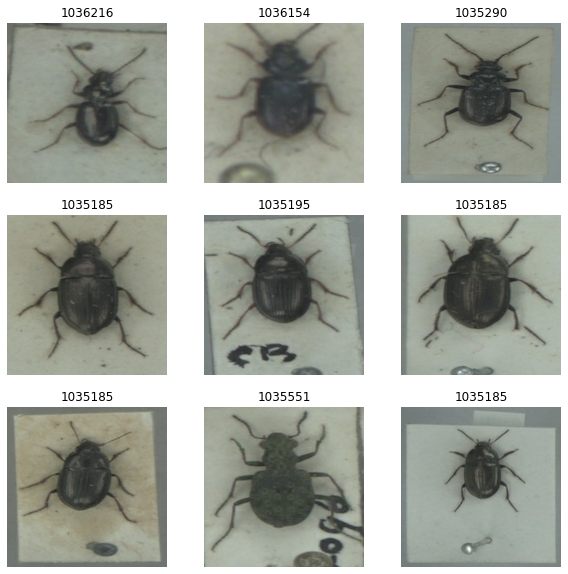

In [4]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Seperate dataset into validation and test

In [5]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 93
Number of validation batches: 31
Number of test batches: 31


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

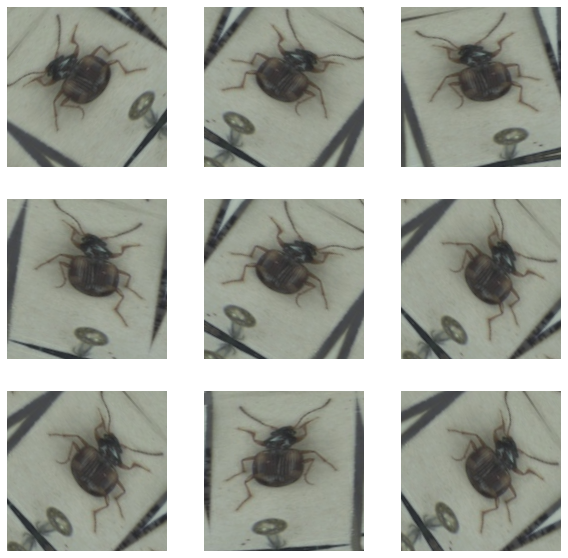

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, we will download `tf.keras.applications.xception.Xception` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.xception.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **xception** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.xception.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x2048` block of features.

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


## Feature extraction
In this step, weu will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.

In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

### Add a classification head

Convert the features to  a single 2048-element vector per image.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. 

In [16]:
# Dense = 10 for 10 classes

In [17]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Use the `tf.keras.losses.SparseCategoricalCrossentropy` loss with `from_logits=True`

In [19]:
# Change BinaryCrossEntropy to CategorialCrossEntropy

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

The 20.8M parameters in Xception are frozen, but there are 20.5K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, we will see ~66% accuracy on the validation set.


In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

31/31 [==============================] - 52s 2s/step - loss: 2.5656 - accuracy: 0.1058


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.57
initial accuracy: 0.11


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
93/93 [==============================] - 216s 2s/step - loss: 2.1914 - accuracy: 0.1998 - val_loss: 1.8773 - val_accuracy: 0.3569
Epoch 2/10
93/93 [==============================] - 188s 2s/step - loss: 1.8047 - accuracy: 0.3509 - val_loss: 1.6167 - val_accuracy: 0.4708
Epoch 3/10
93/93 [==============================] - 197s 2s/step - loss: 1.5854 - accuracy: 0.4442 - val_loss: 1.4485 - val_accuracy: 0.5282
Epoch 4/10
93/93 [==============================] - 202s 2s/step - loss: 1.4234 - accuracy: 0.5091 - val_loss: 1.3300 - val_accuracy: 0.5776
Epoch 5/10
93/93 [==============================] - 203s 2s/step - loss: 1.3337 - accuracy: 0.5311 - val_loss: 1.2433 - val_accuracy: 0.6008
Epoch 6/10
93/93 [==============================] - 191s 2s/step - loss: 1.2529 - accuracy: 0.5524 - val_loss: 1.1895 - val_accuracy: 0.6119
Epoch 7/10
93/93 [==============================] - 194s 2s/step - loss: 1.1950 - accuracy: 0.5892 - val_loss: 1.1280 - val_accuracy: 0.6482
Epoch 8/10
93

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the Xception base model as a fixed feature extractor.

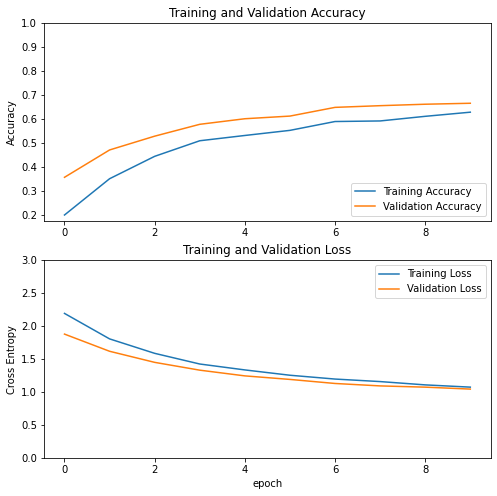

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

### Un-freeze the top layers of the model


In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# fine_tune_at = 100
fine_tune_at = 70

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


### Compile the model


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [31]:
len(model.trainable_variables)

77

### Continue training the model

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
93/93 [==============================] - 416s 4s/step - loss: 0.8598 - accuracy: 0.6859 - val_loss: 0.7226 - val_accuracy: 0.7601
Epoch 11/20
93/93 [==============================] - 409s 4s/step - loss: 0.6343 - accuracy: 0.7701 - val_loss: 0.5746 - val_accuracy: 0.8054
Epoch 12/20
93/93 [==============================] - 389s 4s/step - loss: 0.5175 - accuracy: 0.8103 - val_loss: 0.4765 - val_accuracy: 0.8327
Epoch 13/20
93/93 [==============================] - 407s 4s/step - loss: 0.4660 - accuracy: 0.8266 - val_loss: 0.4475 - val_accuracy: 0.8387
Epoch 14/20
93/93 [==============================] - 410s 4s/step - loss: 0.4087 - accuracy: 0.8502 - val_loss: 0.3911 - val_accuracy: 0.8659
Epoch 15/20
93/93 [==============================] - 410s 4s/step - loss: 0.3580 - accuracy: 0.8753 - val_loss: 0.4009 - val_accuracy: 0.8609
Epoch 16/20
93/93 [==============================] - 401s 4s/step - loss: 0.3203 - accuracy: 0.8857 - val_loss: 0.3606 - val_accuracy: 0.8881
Epoch 

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the Xception base model and training the classifier on top of it.

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

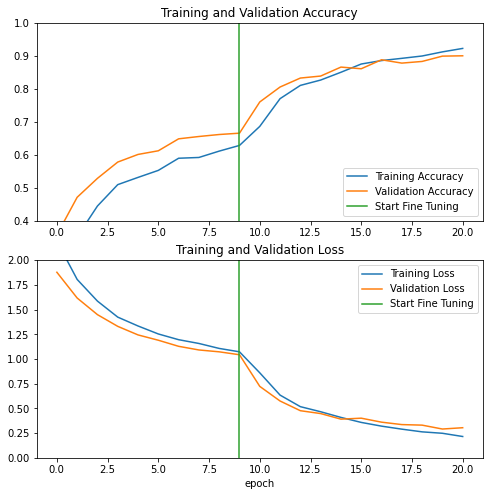

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly we can verify the performance of the model on new data using test set.

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

31/31 [==============================] - 48s 2s/step - loss: 0.3264 - accuracy: 0.8891
Test accuracy : 0.8891128897666931
